In [106]:
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from xgboost import plot_importance

In [107]:
data = pd.read_csv('data.csv')

In [108]:
X = data.drop(columns=['heartRateVariabilitySDNN_target', 'heartRateVariabilitySDNN_tomorrow', 'heartRateVariabilitySDNN_mean', 'time'])
y = data['heartRateVariabilitySDNN_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)

param_grid = {
    'objective': ['binary:logistic'],
    'learning_rate': [0.05, 0.1],
    'min_child_weight': [1, 20],  
    'max_depth': [3, 6],
    'subsample': [0.8],  
    'colsample_bytree': [0.8],  
    'gamma': [0, 0.1],  
    'reg_lambda': [0, 0.1], 
}


xgb = XGBClassifier(n_estimators=100, early_stopping_rounds=50)
grid_search = GridSearchCV(xgb, param_grid, cv=4, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

Fitting 4 folds for each of 32 candidates, totalling 128 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, objective=binary:logistic, reg_lambda=0, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, objective=binary:logistic, reg_lambda=0, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, objective=binary:logistic, reg_lambda=0.1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, objective=binary:logistic, reg_lambda=0.1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, objective=binary:logistic, reg_lambda=0, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, o

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=50,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, ma...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8], 'gamma': [0, 0.1],
                         'learning_rate': [0.05, 0.1], 'max_depth': [3, 6],
                         'min_child_weight': [1, 20],
                         'objective': ['binary:logistic'],
                         'reg_lambda': [0, 0.1], 'subsample': [0.8]},
             verbose=2)

In [109]:
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)
optimized_xgb = XGBClassifier(**best_params)
optimized_xgb.fit(X_train, y_train)

Best parameters found:  {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 1, 'objective': 'binary:logistic', 'reg_lambda': 0, 'subsample': 0.8}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

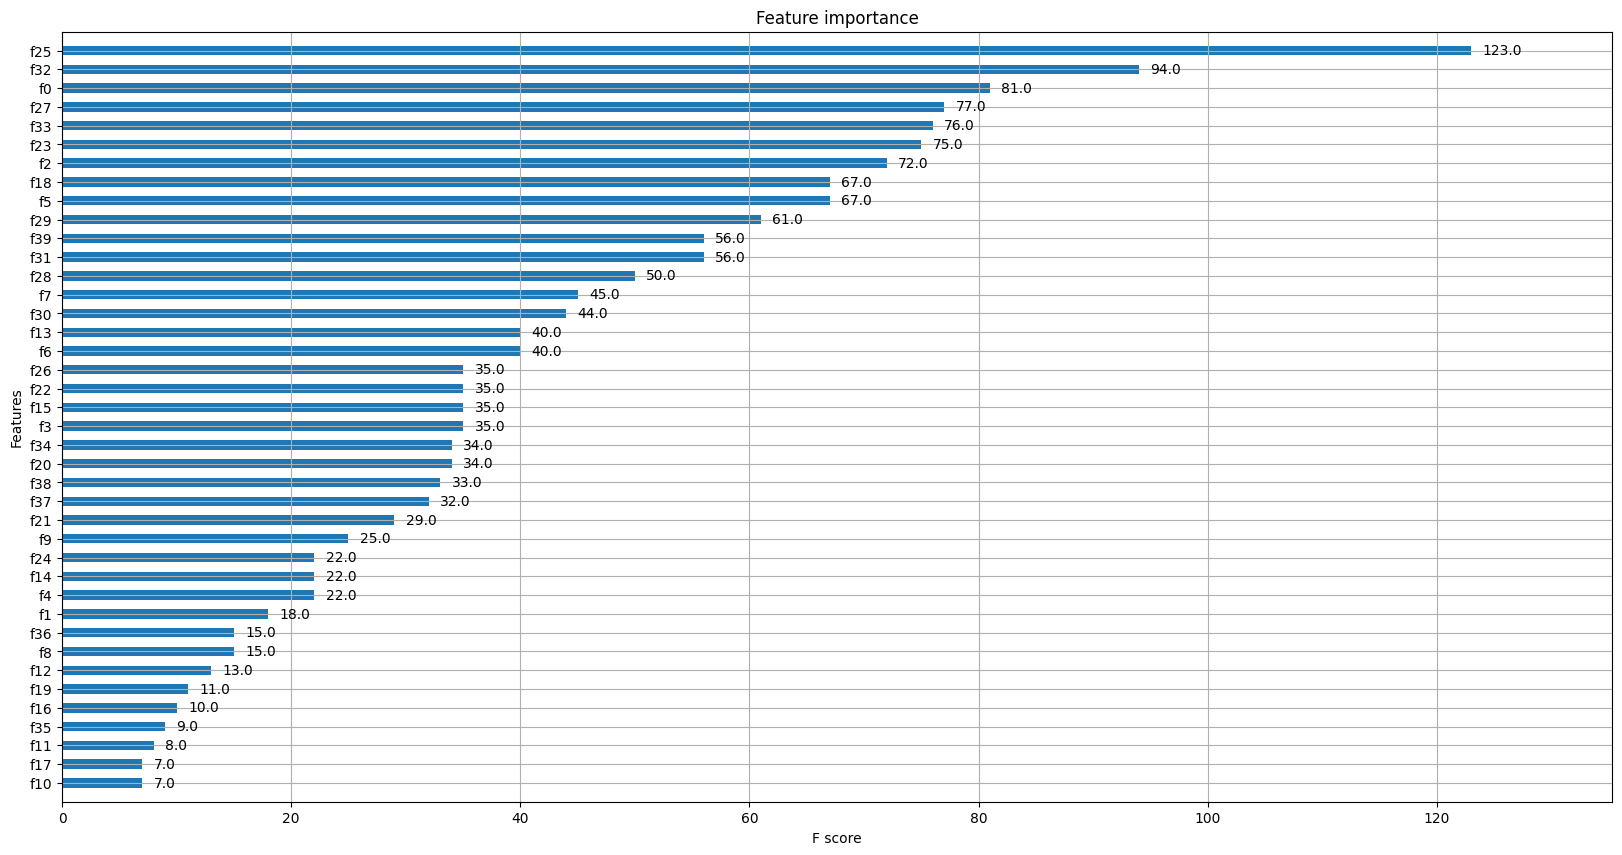

In [110]:
# feature_names = list(X.columns)
# print("feature names: ", feature_names)
optimized_xgb.get_booster().feature_names
plt.rcParams["figure.figsize"] = (20, 10)
plot_importance(optimized_xgb, height=0.5)

<Axes: >

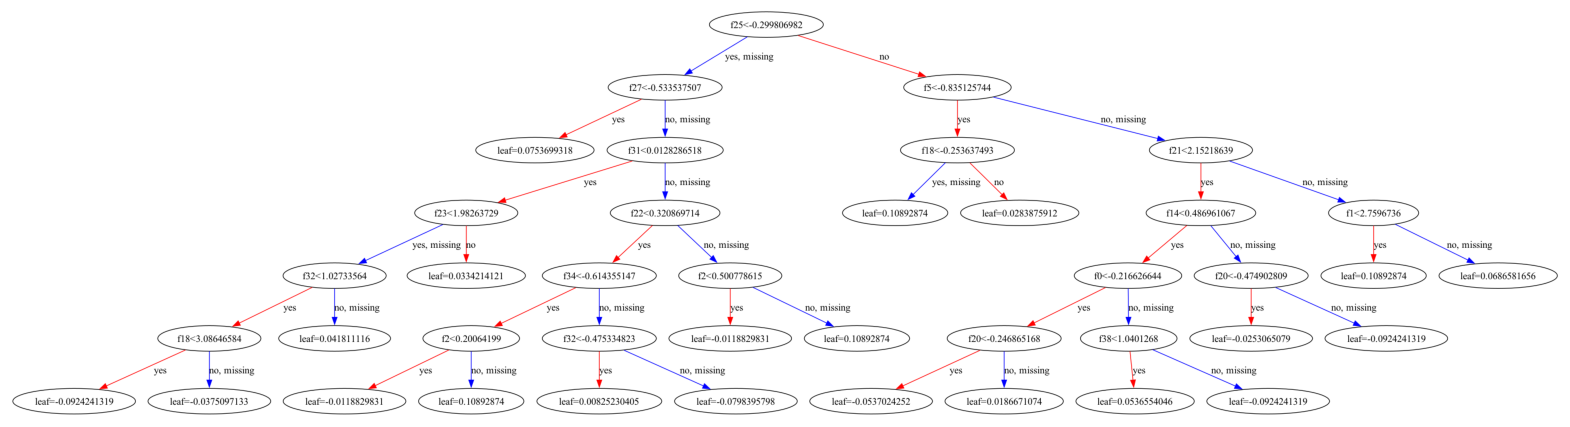

In [111]:
import xgboost
xgboost.plot_tree(optimized_xgb)

In [112]:
new_predictions = optimized_xgb.predict(X_test)

print(f'accuracy: {accuracy_score(y_test, new_predictions)}')

accuracy: 0.48314606741573035


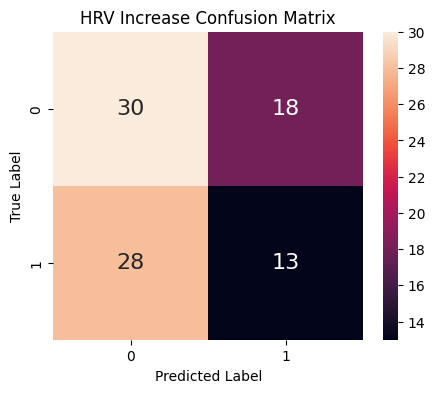

In [113]:
def plot_confusion_matrix(y_test, y_predicted):  
    conf_mat = pd.DataFrame(confusion_matrix(y_test, y_predicted))  
    plt.figure(figsize=(5, 4))  
    sns.heatmap(conf_mat, annot=True, annot_kws={"size": 16}, fmt="g")  
    plt.title("HRV Increase Confusion Matrix")  
    plt.xlabel("Predicted Label")  
    plt.ylabel("True Label")  
    plt.show()  
   
plot_confusion_matrix(y_test, new_predictions) 

In [114]:
print(classification_report(y_test, new_predictions))

              precision    recall  f1-score   support

           0       0.52      0.62      0.57        48
           1       0.42      0.32      0.36        41

    accuracy                           0.48        89
   macro avg       0.47      0.47      0.46        89
weighted avg       0.47      0.48      0.47        89

